<a href="https://colab.research.google.com/github/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 - New Cases, Deaths, Recovered - Death Rate - Reproduction Number (R)

Generated with data from Johns Hopkins CSSE: https://github.com/CSSEGISandData
and population data from [The World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL)


Configuration options


In [1]:
selected_countries = ['Germany', 'France', 'Spain', 'Italy', 'Argentina', 'US', 'Brazil']
days_rolling_average = 10
per_x_people = 100000

To run the code either select **'Runtime' -> 'Run All'** from the main menu

or

press **CTRL+F9** (Windows/Linux) / **⌘+F9** (Mac)


In [2]:
#@title

# import libraries
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [25, 15]
import numpy as np
import pandas as pd

print("Downloading data from Johns Hopkins CSSE and Worldbank ... \n")

# Download the Johns Hopkins CSSE global dataset for Covid-19
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
# Download population numbers from Wordbank and unzip it
!curl -o population.zip http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
!unzip -o population.zip
!mv API_SP.POP.TOTL_DS2_en_csv*.csv population.csv

print("\nProcessing the downloaded data ...\n")

# Load the downloaded dataset (csv files) into Pandas dataframes
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, 
                           error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, 
                        error_bad_lines=False)
recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, 
                           error_bad_lines=False)
population_df = pd.read_csv('population.csv', sep=',', header=2,
                            error_bad_lines=False)

# create the dataframe with the population numbers
population_df = population_df[['Country Name','2019']]
population_df.columns = ['Country','Population']
population_df.set_index('Country', inplace=True)
population_df = population_df.rename(index={'United States':'US'})
population_df = population_df.loc[population_df.index.isin(selected_countries)].copy()

# Define helper functions

# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & \
                         df['Province/State'].isnull()].copy()

    selected_df.rename(columns={'Country/Region':'Country'}, inplace=True)
    selected_df.set_index('Country', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df


# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    # get rid of negative values
    diff_df[diff_df < 0] = 0
    return diff_df
    

# Add a new column with the population for each country and then
# calculate the cases per x people 
def calculate_cases_per_x_people(df):
    selected_df = get_selected_countries(df)
    new_df = get_difference_between_days(selected_df)
    new_df.insert(0, 'Population', population_df.Population)
    # Calculate cases per x people
    new_df = new_df.iloc[:, 1:].div(new_df.iloc[:,0], axis='index') * per_x_people
    return new_df


# Plot the graph 
def plot_curve(df, title):
    title = (title + ' per '+ str(per_x_people) + ' people ('
             + str(days_rolling_average) + ' day rolling average)')
    df.transpose().rolling(days_rolling_average, 
                           min_periods=1, 
                           win_type='gaussian').mean(std=3).plot(kind='line', 
                                                                 title=title,
                                                                 logy=False)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  292k  100  292k    0     0  2253k      0 --:--:-- --:--:-- --:--:-- 2236k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  204k  100  204k    0     0  1829k      0 --:--:-- --:--:-- --:--:-- 1829k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  260k  100  260k    0     0  2173k      0 --:--:-- --:--:-- --:--:-- 2192k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80062  100 80062    0     0  85811      0 --:--:-- --:--:-- --:--:-- 85719
Archive:  population.zip
  inflating: Metadata_Indi

## New Confirmed Cases

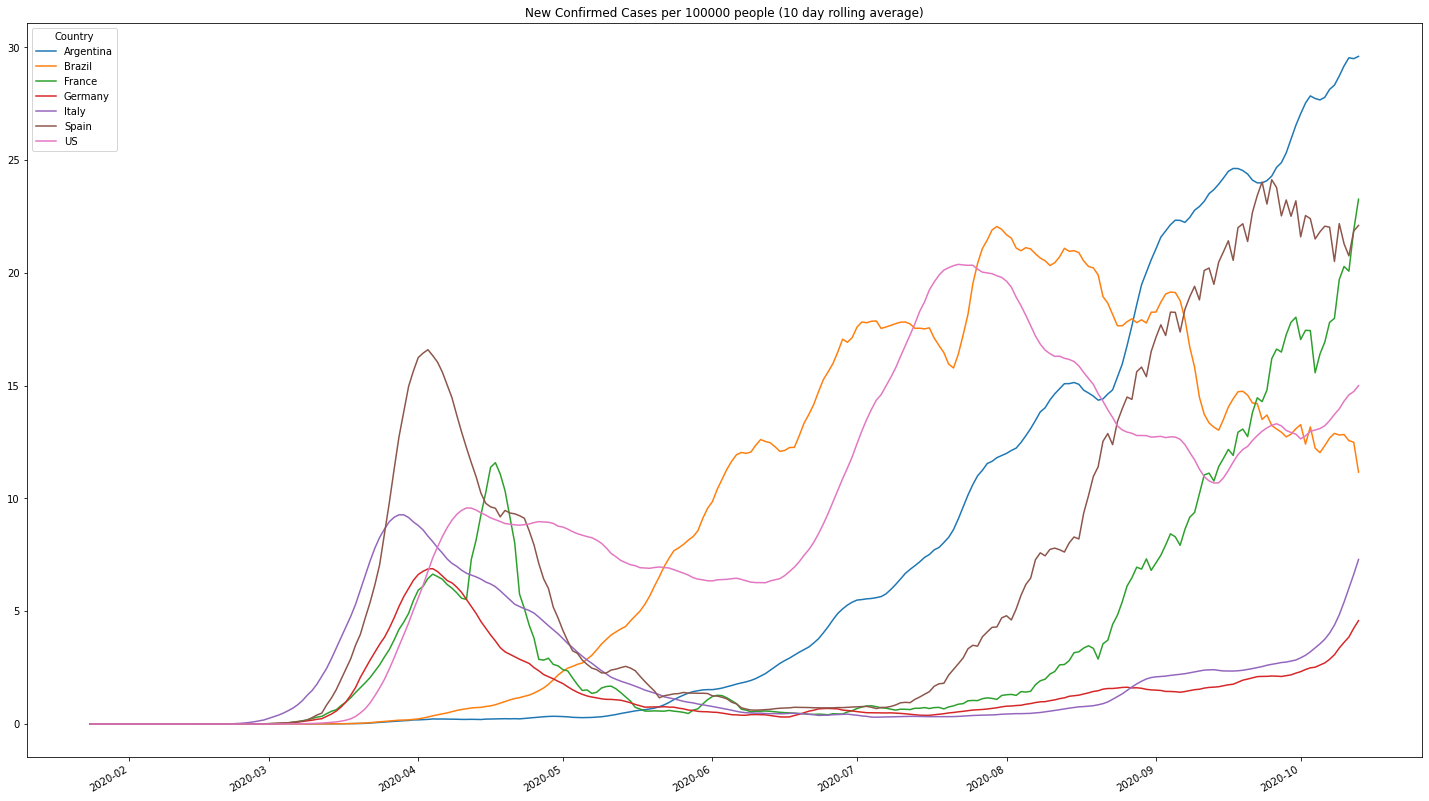

In [3]:
#@title
xconfirmed_df = calculate_cases_per_x_people(confirmed_df)
plot_curve(xconfirmed_df, 'New Confirmed Cases')

## New Deaths




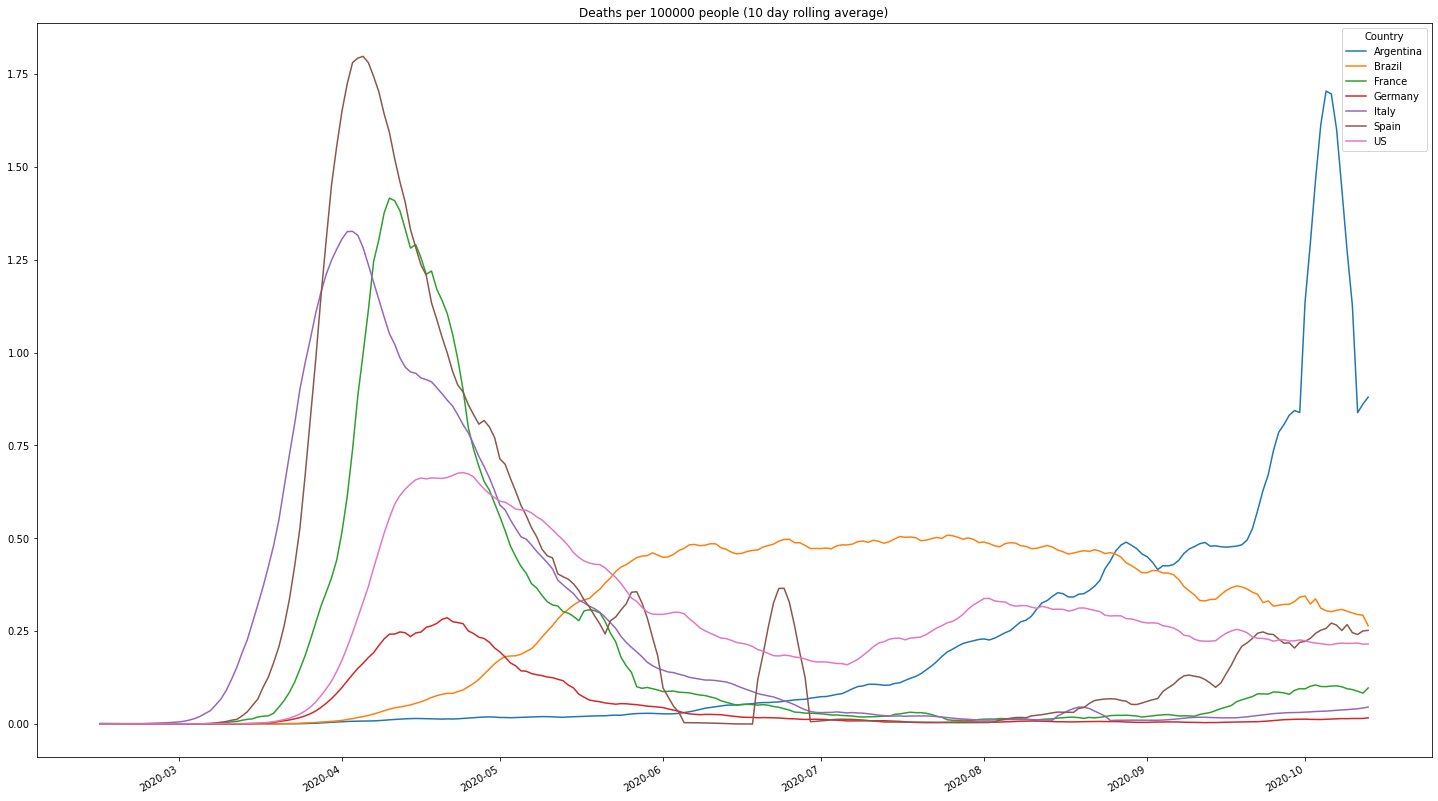

In [4]:
#@title
xdeaths_df =  calculate_cases_per_x_people(deaths_df)
plot_curve(xdeaths_df, 'Deaths')

## New Recovered Patients

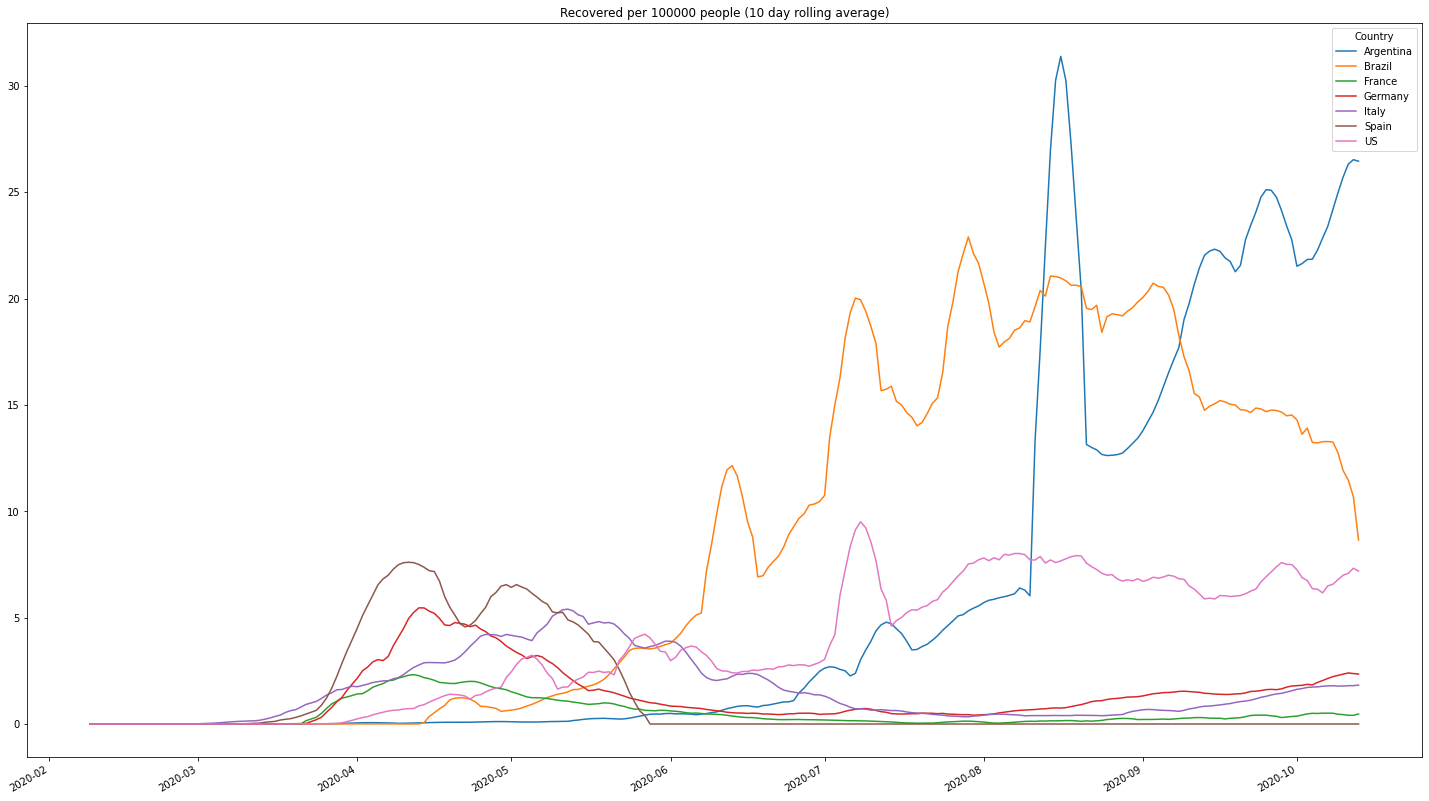

In [5]:
#@title
xrecovered_df =  calculate_cases_per_x_people(recovered_df)

plot_curve(xrecovered_df, 'Recovered')

## Calculate death rate based on all cases (recovered, deaths, still with Covid-19)

In [6]:
#@title

selected_deaths_df = get_selected_countries(deaths_df)
selected_confirmed_df = get_selected_countries(confirmed_df)
selected_recovered_df = get_selected_countries(recovered_df)

death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country
Argentina    0.026795
Brazil       0.029529
France       0.042684
Germany      0.028703
Italy        0.099177
Spain        0.037054
US           0.027478
Name: 2020-10-13 00:00:00, dtype: float64

## Calculate death rate based on number of recovered patients plus deaths

In [7]:
#@title

death_rate_vs_recovered = selected_deaths_df.iloc[:,-1] / \
                          (selected_recovered_df.iloc[:,-1] + \
                           selected_deaths_df.iloc[:,-1])
death_rate_vs_recovered

Country
Argentina    0.032045
Brazil       0.032283
France       0.281391
Germany      0.033361
Italy        0.130253
Spain        0.180869
US           0.064628
Name: 2020-10-13 00:00:00, dtype: float64

## Calculate reproduction number 
Last four days vs. previous four days 

```Reff(t) = (N(t)+N(t-1)+N(t-2)+N(t-3)) / (N(t-4)+N(t-5)+N(t-6)+N(t-7))``` 

In [8]:
#@title

new_confirmed_df = get_difference_between_days(selected_confirmed_df)

# divide new cases from last four days with new cases from previous four days
reproduction_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4]) \
                  / (new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7] \
                   + new_confirmed_df.iloc[:,-8])
reproduction_df

Country
Argentina    0.738047
Brazil       0.448804
France       0.974542
Germany      1.063014
Italy        1.340645
Spain        0.733208
US           0.938905
dtype: float64

## Display the number of new confirmed cases for the last 8 days

In [9]:
#@title
new_confirmed_df.iloc[:,-8:]

,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13
Country,,,,,,,,
Argentina,14740.0,16447.0,15454.0,15099.0,12414.0,10324.0,9524.0,13305.0
Brazil,41906.0,31553.0,27750.0,27444.0,26749.0,12342.0,8429.0,10220.0
France,10335.0,17647.0,18014.0,19956.0,0.0,0.0,42956.0,21317.0
Germany,2454.0,4010.0,4804.0,4554.0,2968.0,2846.0,6541.0,4464.0
Italy,2677.0,3677.0,4458.0,5372.0,5724.0,5456.0,4619.0,5898.0
Spain,11998.0,10491.0,12423.0,12788.0,0.0,0.0,27856.0,7118.0
US,41939.0,50341.0,56191.0,57420.0,54639.0,44614.0,41653.0,52406.0
